In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import utils
from helper_functions.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import pickle as pkl
utils.default_plot_format()
utils.pd_display_settings(3)

In [75]:
import os

data_path = "our_processing/Nabian_2025_10_11.pkl"
htmL_save_folder = "html_plots/new_metrics"


# Create the save folder if it doesn't exist
if not os.path.exists(htmL_save_folder):
    os.makedirs(htmL_save_folder)

In [76]:
utils.pd_display_settings(3)

data = pd.read_pickle(data_path)
data.head()

data.rename(columns={
    'Diabetic Complications': 'Complications',
    'Diabetic nephropathy': 'Nephropathy',
    'Diabetic retinopathy and cataract': 'Retinopathy and cataract',
    'Diabetic peripheral neuropathy': 'DPN',
    'Coronary artery disease and cardiac insufficiency': 'Heart Disease',
    'Lower extremity atherosclerosis or stenosis': 'atherosclerosis or stenosis',
    'Carotid plaque': 'Carotid Plaque'
}, inplace=True)



In [77]:
data = data[(data["Complications"] == 0) | (data["DPN"] == 1)]
data["DPN"] = data["DPN"].astype(bool)

data['Condition'] = data['DPN'].apply(lambda x: 'DPN' if x else 'Diabetes')
data.head()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UCr (g),UACR (mg/g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
0,0,300,60.93,61.35,4.42,81.42,0,0,3.71,0.0267,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
1,300,600,58.91,36.23,3.90,82.09,0,0,1.84,0.03,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
2,600,900,91.85,71.25,12.10,74.51,0,0,7.00,0.0234,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
3,900,1200,93.23,90.24,13.39,73.35,0,0,2.37,0.02,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
4,1200,1500,51.21,33.28,10.95,69.57,0,0,4.53,0.0368,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes


In [78]:
data = data[data['SDRR'] <= 500]
data = data[data['RMSSD'] <= 500]

In [79]:
indicator_columns = data.columns[2:24]

indicator_columns = indicator_columns.drop(['ULF Power','ULF Peak Frequency'])
print(indicator_columns)

Index(['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF/HF Ratio', 'S', 'SD1', 'SD2', 'SD1/SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object')


In [112]:
time_metrics = ['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)']
frequency_metrics = ['VLF Power', 'LF Power', 'HF Power', 'LF/HF Ratio']
non_linear_metrics = ['S', 'SD1', 'SD2', 'SD1/SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']

# Resample mean for each condition repeatedly


In [80]:
control_ID = data[~data['DPN']].id.unique()
DPN_ID = data[data['DPN']].id.unique()

print(control_ID, DPN_ID)

['19070921' '19072205' '19072214' '19072938' '19072939' '19072940'
 '19080106' '19081506' '19082406' '19090308' '19090320' '19102102'
 '19102524' '19112609' '19121303' '19121735' '20050628' '20052606'
 '20061729' '20120922' '20121033' '20121718'] ['19101619' '20010826' '20101822' '20123017']


## Reusable revamper function

In [ ]:
import numpy as np
class DistributionSampler():
    def __init__(self, data, n=5000):
        self.data = data
        self.n = n
        self.memory = {}

    def sample_metric(self, metric, id):
        """Sample a single value of a metric for a given id"""
        return self.data.loc[self.data['id'] == id, metric].sample(1).values[0]

    def sample_group_metric(self, metric, ids):
        """Sample a single value of a metric for each id"""
        return [self.sample_metric(metric, ID) for ID in ids]

    def get_distribution(self, metric, ids, agg_func=np.mean):
        """Get a distribution of a metric for a group of ids"""
        values = [self.sample_group_metric(metric, ids) for _ in range(self.n)]
        distribution = [agg_func(group) for group in values]
        return distribution
    
    def check_metric(self, metric):
        """RENAME, get the distribution of a metric for both DPN and control group"""
        self.memory[metric] ={'DPN': self.get_distribution(metric, DPN_ID),
                                'Control':self.get_distribution(metric, control_ID)}
        return self.memory[metric]

bootstrap each metric for control and dnp separately.

The data is pickled, since looking at each metric with n=5000 takes about 30 min

In [ ]:
sampler = DistributionSampler(data)

if os.path.exists("sampler_memory.pkl"):
    sampler.memory = pkl.load(open("sampler_memory.pkl", "rb"))
else:
    for metric in indicator_columns:
        sampler.check_metric(metric)

    pkl.dump(sampler.memory, open("sampler_memory.pkl", "wb"))


,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,SDRR,0.18,57.00,25.56,83.30,10.64


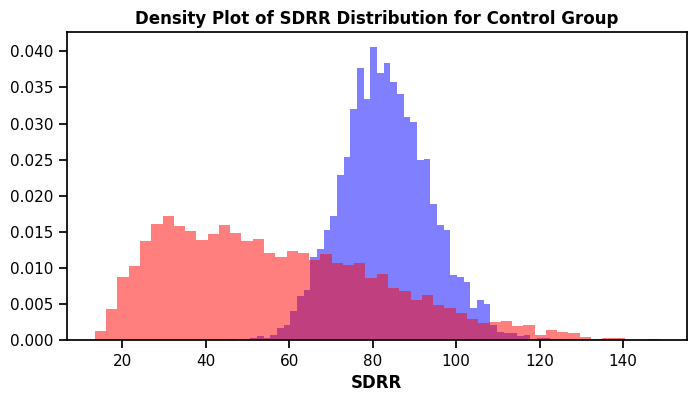

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,RMSSD,0.21,56.68,31.41,82.53,13.50


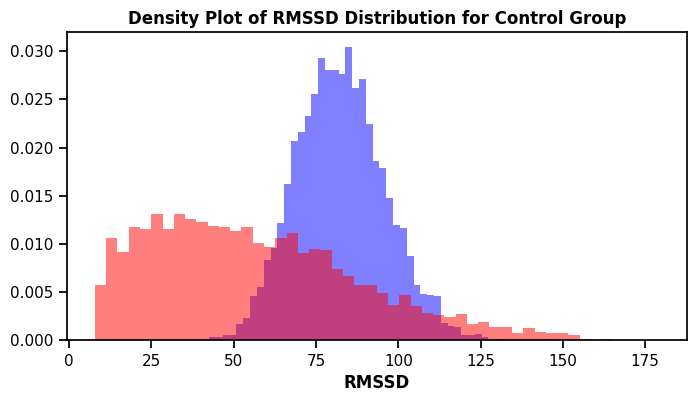

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,pNN50 (%),0.12,6.23,5.40,14.25,3.23


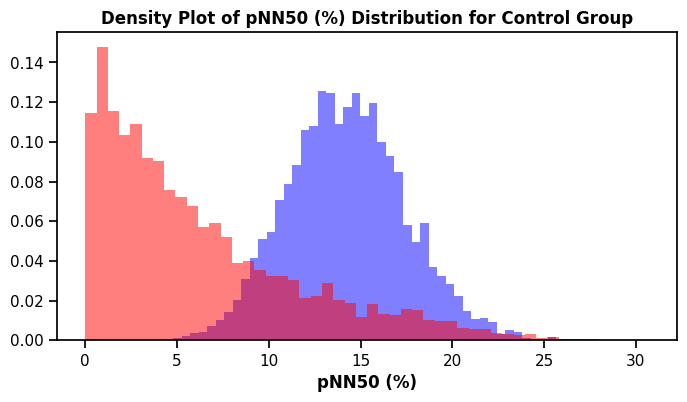

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,Mean HR (bpm),0.0576,83.62,4.87,75.34,2.05


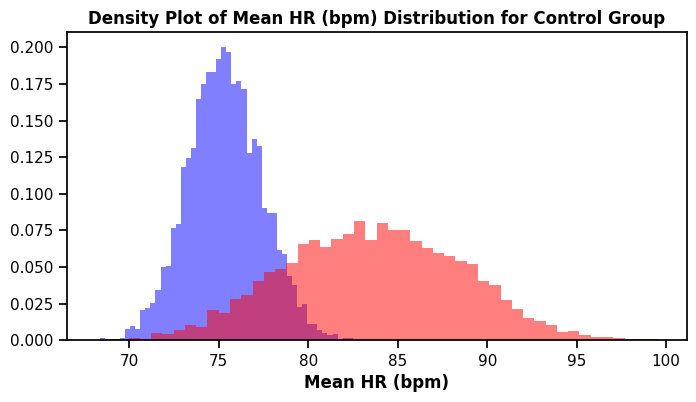

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,VLF Power,0.20,3.62,5.21,6.08,2.19


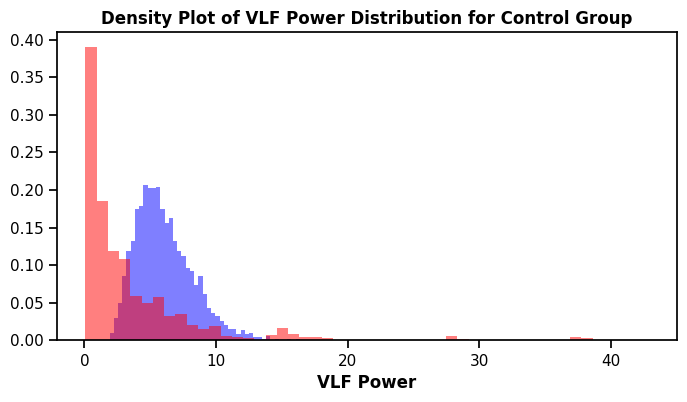

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,VLF Peak Frequency,0.34,0.0275,0.00407,0.0293,0.00148


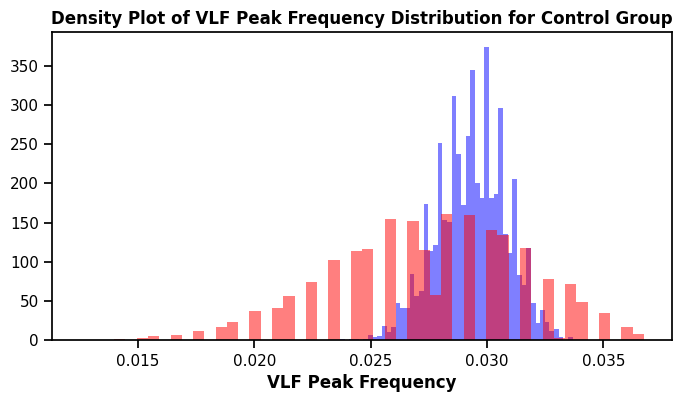

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,LF Power,0.28,105.98,129.65,145.97,60.37


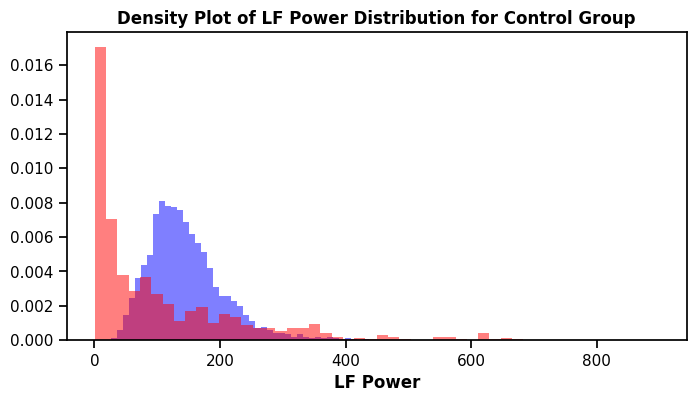

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,LF Peak Frequency,0.36,0.0989,0.0166,0.11,0.00646


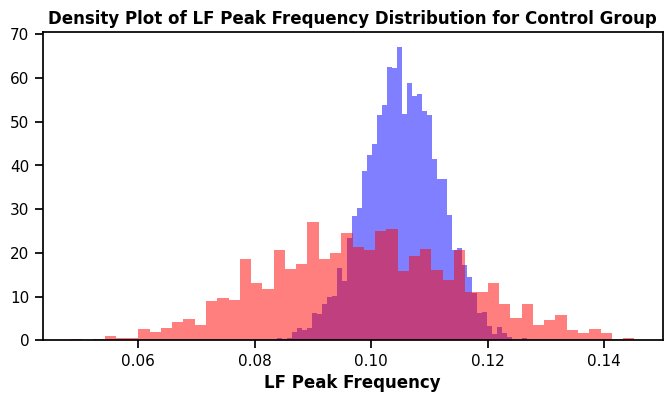

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,HF Power,0.31,1632,1853,2199,901.35


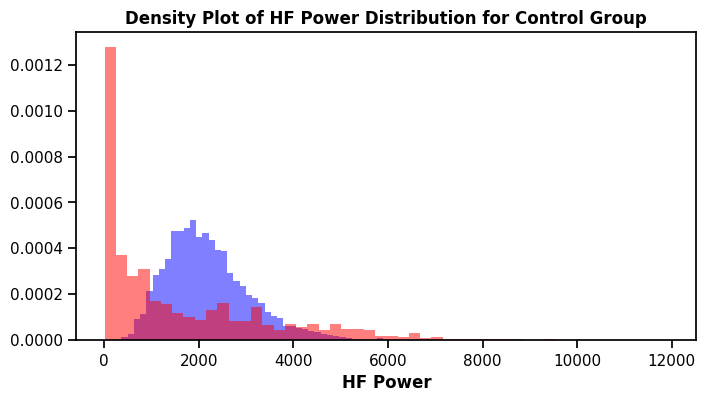

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,HF Peak Frequency,0.25,0.34,0.0237,0.32,0.0113


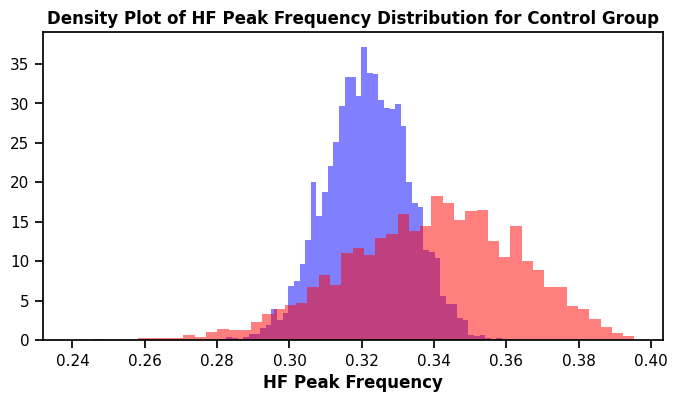

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,LF/HF Ratio,0.38,0.13,0.0577,0.14,0.0313


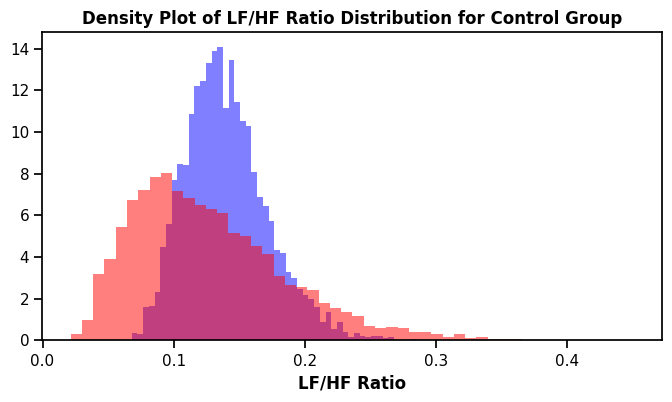

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,S,0.27,19158,18422,28881,8837


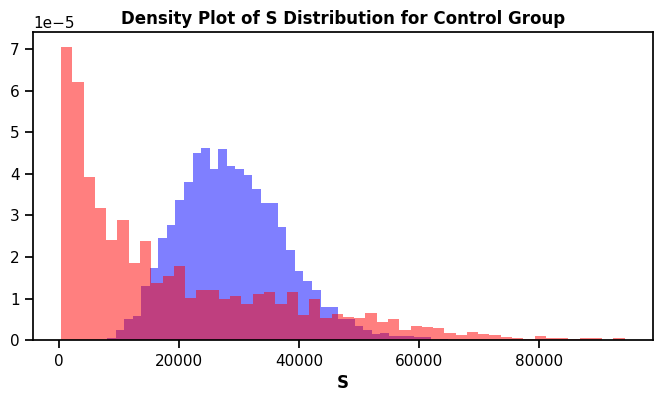

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,SD1,0.21,39.23,21.40,58.16,9.73


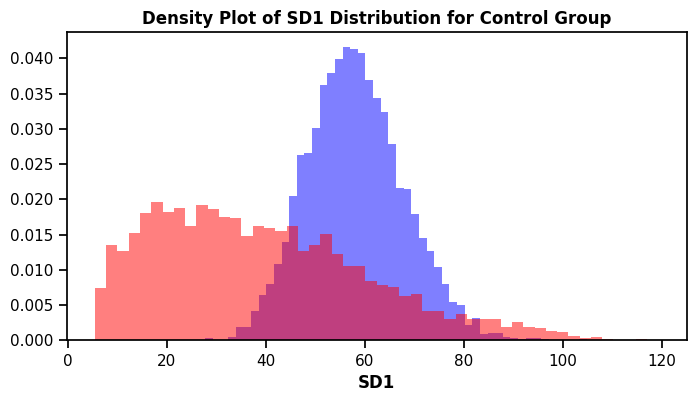

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,SD2,0.17,68.44,29.45,100.15,12.13


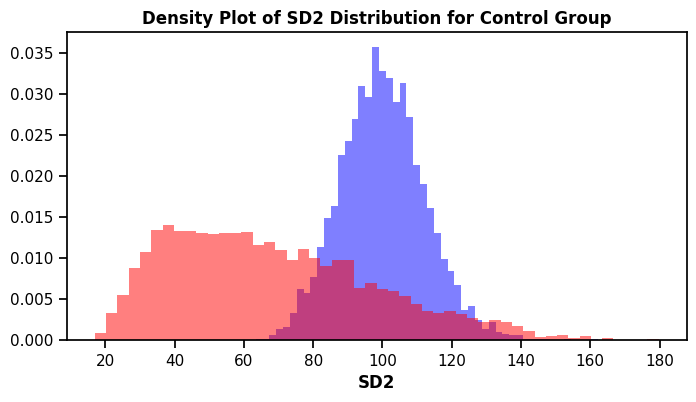

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,SD1/SD2,0.33,0.48,0.12,0.53,0.0451


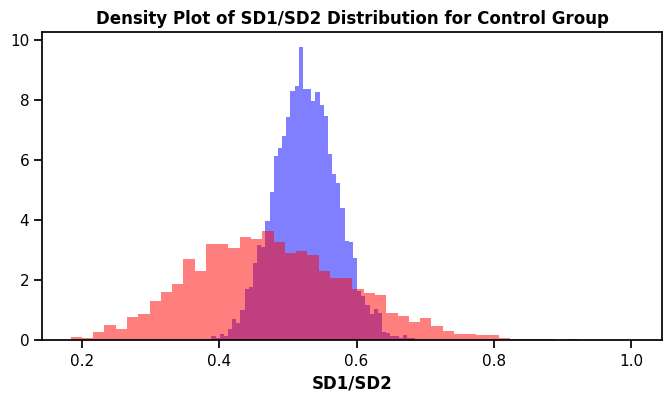

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,ApEn,0.45,0.86,0.13,0.88,0.0461


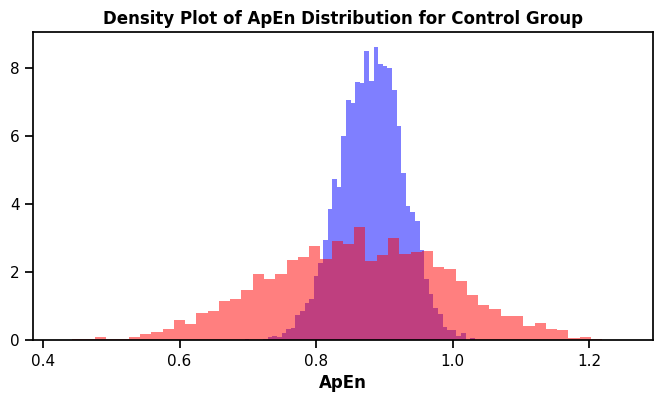

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,SampEn,0.50,1.03,0.27,1.02,0.09


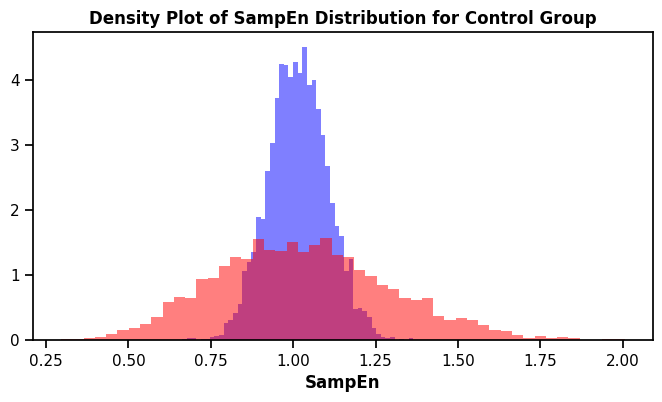

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,DFA α1,0.49,0.94,0.14,0.94,0.0539


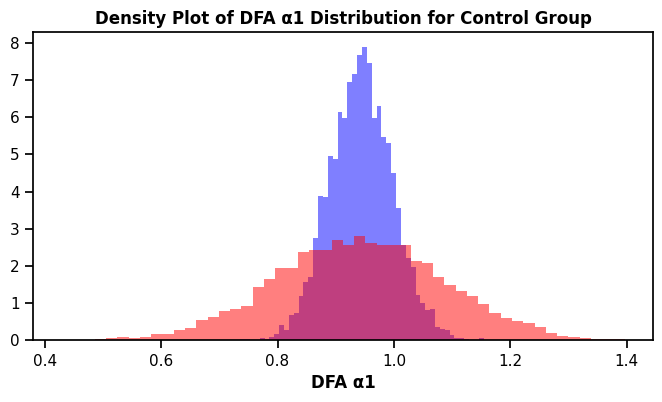

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,DFA α2,0.24,0.97,0.13,0.87,0.0476


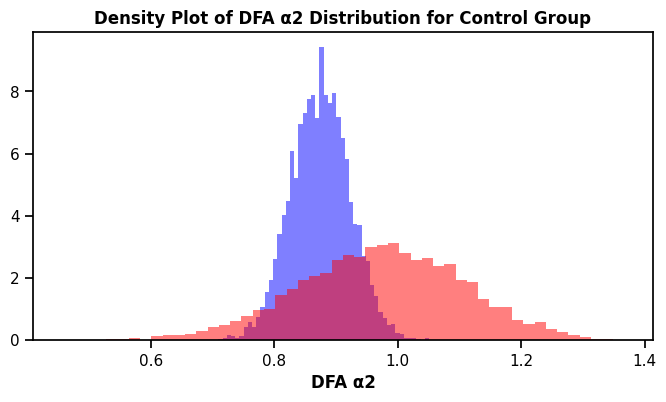

,Metric,Bayes p,DPN Mean,DPN Std,Control Mean,Control Std
0,D2,0.0892,-3.23,11.70,-2.51,0.25


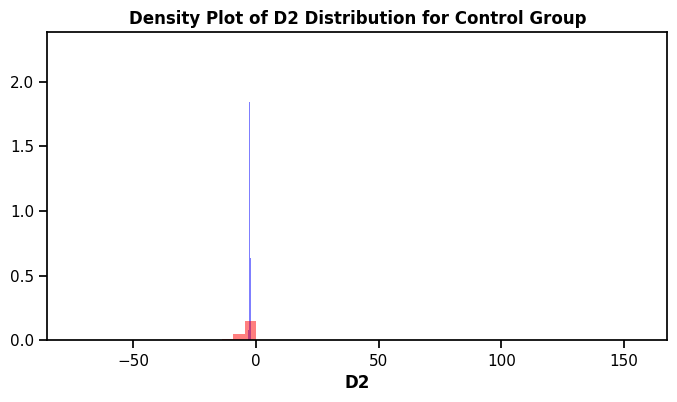

In [111]:
from scipy.stats import ttest_ind

def draw_metric(control, dpn, metric, draw = False):
    bayes_p = np.mean(pd.Series(control) < pd.Series(dpn))
    results = {
        'Metric': metric,
        #'T-test': ttest_ind(control, dpn)[1],
        'Bayes p': bayes_p if bayes_p < 0.5 else 1 - bayes_p,
        'DPN Mean': np.mean(dpn),
        'DPN Std': np.std(dpn),
        'Control Mean': np.mean(control),
        'Control Std': np.std(control)
    }
    results_df = pd.DataFrame([results])
    display(results_df)


    if draw:
        plt.figure(figsize=(8, 4))
        plt.hist(control, bins=50, density=True, alpha=0.5, color='blue')
        plt.hist(dpn, bins=50, density=True, alpha=0.5, color='red')
        plt.title(f'Density Plot of {metric} Distribution for Control Group')
        plt.xlabel(metric)
        plt.show()

for metric in indicator_columns:
    draw_metric(sampler.memory[metric]['Control'], sampler.memory[metric]['DPN'], metric, draw=True)